### Import libraries

In [95]:
import math

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from prophet import Prophet

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Loading dataset

In [33]:
df = pd.read_csv('purchases_monthly.csv')

In [34]:
df.head()

,dim_product_sk,year_month,amount,quantity,year,month
0,5,2019-01,4008.34,95.0,2019,1
1,5,2019-02,8282.05,197.0,2019,2
2,5,2019-03,5168.46,123.0,2019,3
3,5,2019-04,3659.85,87.0,2019,4
4,5,2019-05,6643.27,158.0,2019,5


### Data information

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180831 entries, 0 to 180830
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dim_product_sk  180831 non-null  int64  
 1   year_month      180831 non-null  object 
 2   amount          180831 non-null  float64
 3   quantity        180831 non-null  float64
 4   year            180831 non-null  int64  
 5   month           180831 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 8.3+ MB


### Data Cleaning

### Check for missing values

In [36]:
print(f"Number of rows with missing values: \n{df.isna().sum()}")

Number of rows with missing values: 
dim_product_sk    0
year_month        0
amount            0
quantity          0
year              0
month             0
dtype: int64


### Check for duplicate values

In [37]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


### Check for negative values

In [38]:
print(f"Negative quantity rows: {(df['quantity'] < 0).sum()}")
print(f"Negative amount rows: {(df['amount'] < 0).sum()}")

Negative quantity rows: 0
Negative amount rows: 0


### Univariate analysis

### Unique products

In [39]:
print(f"Unique SK Products : {df['dim_product_sk'].nunique()}")

Unique SK Products : 2289


### Monthly sold quantity

<Axes: xlabel='month'>

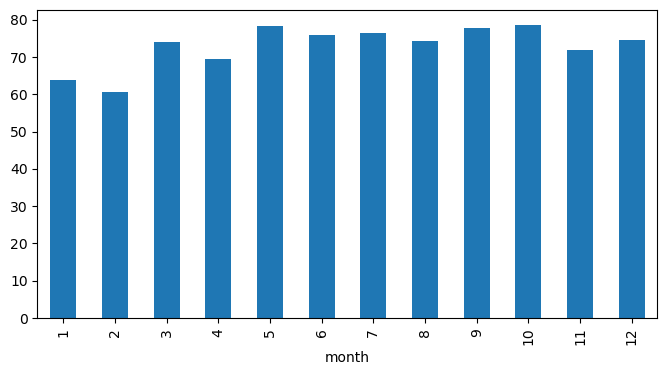

In [40]:
df.groupby('month')['quantity'].mean().plot(kind="bar", figsize=(8, 4))

### Monthly sold amount

<Axes: xlabel='month'>

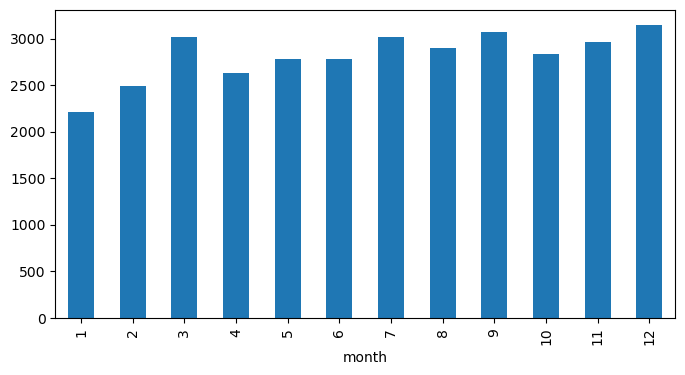

In [41]:
df.groupby('month')['amount'].mean().plot(kind="bar", figsize=(8,4))

### Yearly sold quantity

<Axes: xlabel='year'>

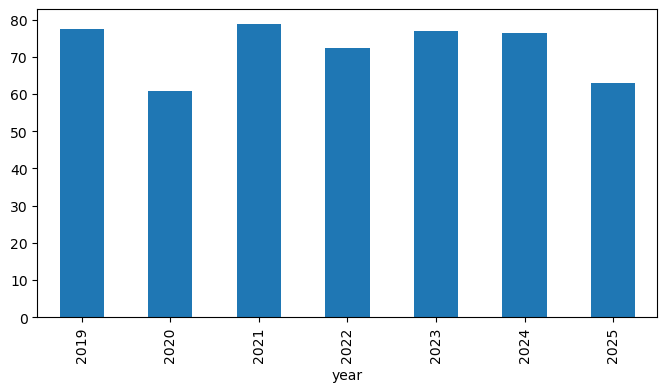

In [42]:
df.groupby('year')['quantity'].mean().plot(kind='bar', figsize=(8,4))

### Yearly sold amount

<Axes: xlabel='year'>

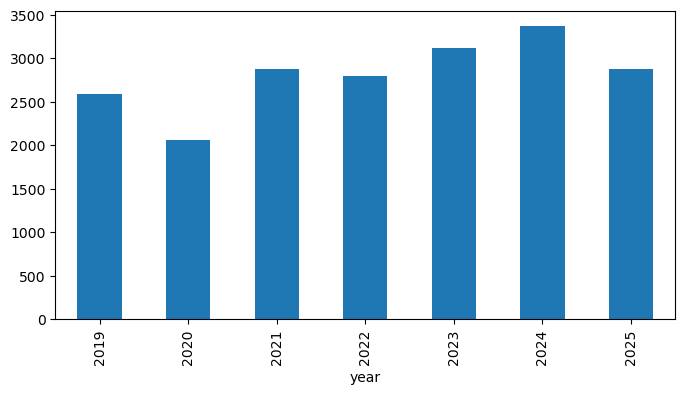

In [43]:
df.groupby('year')['amount'].mean().plot(kind='bar', figsize=(8,4))

### Decomposition

In [44]:
df['year_month'] = pd.to_datetime(df['year_month'])

### Visualizing for trends

In [45]:
df_trends = df.groupby('year_month')['quantity'].sum()

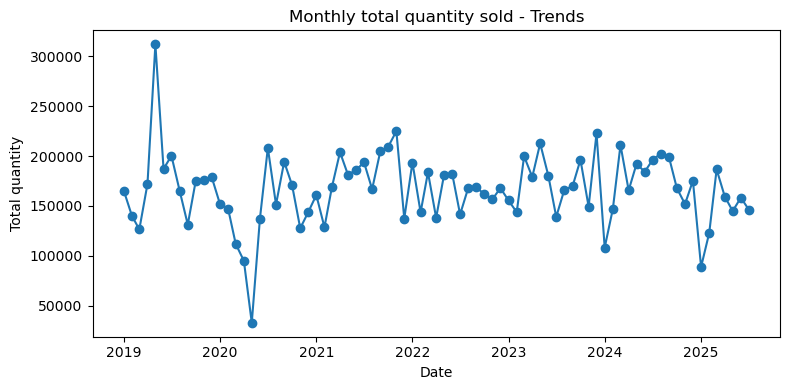

In [46]:
plt.figure(figsize=(8,4))
plt.plot(df_trends.index, df_trends.values, label="Quantity sold", marker = 'o')
plt.title('Monthly total quantity sold - Trends')
plt.xlabel('Date')
plt.ylabel('Total quantity')
plt.tight_layout()
plt.show()

### Visualizing for seasonality

In [47]:
df_seasonality = df.groupby('month')['quantity'].mean()

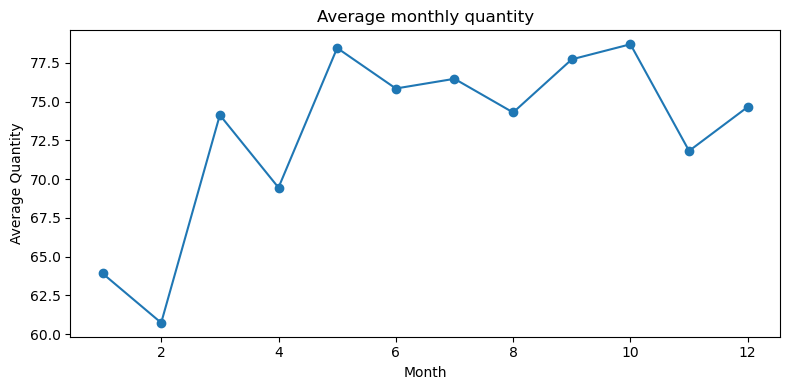

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(df_seasonality.index, df_seasonality.values, marker='o', label='Quantity sold')
plt.title('Average monthly quantity')
plt.xlabel('Month')
plt.ylabel('Average Quantity')
plt.tight_layout()
plt.show()

### Visualizing noise

In [49]:
df_ts_decomposition = seasonal_decompose(df['quantity'], model='additive', period=12)

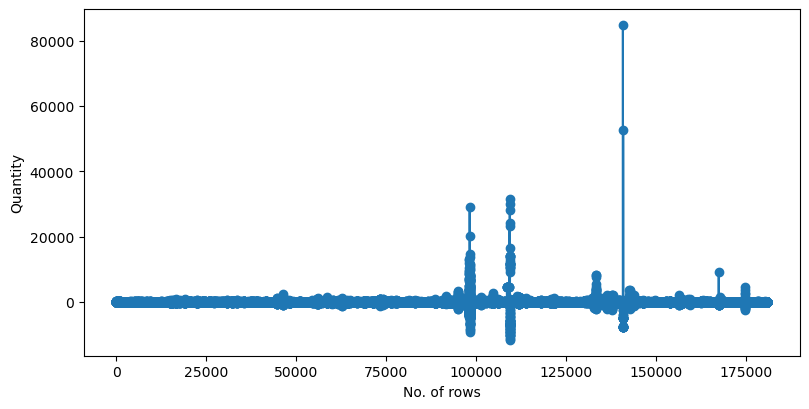

In [50]:
plt.figure(figsize=(8,4))
residuals = df_ts_decomposition.resid
reisduals = residuals.dropna()
plt.plot(residuals.index, residuals, label="Noise", marker='o')
plt.tight_layout()
plt.xlabel('No. of rows')
plt.ylabel('Quantity')
plt.show()

## ADF test

In [51]:
df_monthly = df.groupby('year_month')['quantity'].sum()

In [52]:
adftest_result = adfuller(df_monthly)

In [53]:
print('ADF Test on monthly quantity \n')
print("ADF Test Statistic:", adftest_result[0])
print(f"p-value: , {adftest_result[1]:.10f}")
print("Lags Used:", adftest_result[2])
print("Number of Observations:", adftest_result[3])

print("Critical Values:")
for key, value in adftest_result[4].items():
    print(f"   {key}: {value:.3f}")

if adftest_result[1] <= 0.05:
    print("Series is stationary - reject null hypothesis")
else:
    print("Series is non-stationary - (fail to reject null hypothesis)")

ADF Test on monthly quantity 

ADF Test Statistic: -6.770959965130491
p-value: , 0.0000000026
Lags Used: 0
Number of Observations: 78
Critical Values:
   1%: -3.517
   5%: -2.899
   10%: -2.587
Series is stationary - reject null hypothesis


### Autocorrelation function test

<Figure size 800x400 with 0 Axes>

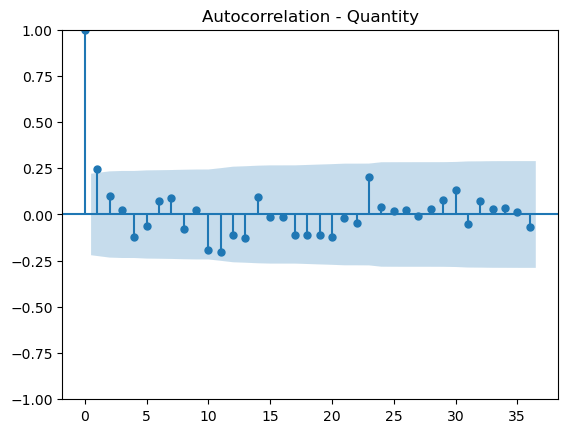

In [54]:
plt.figure(figsize=(8, 4))
plot_acf(df_monthly, lags=36)
plt.title("Autocorrelation - Quantity")
plt.show()

### Partial autocorrelation function test

<Figure size 800x400 with 0 Axes>

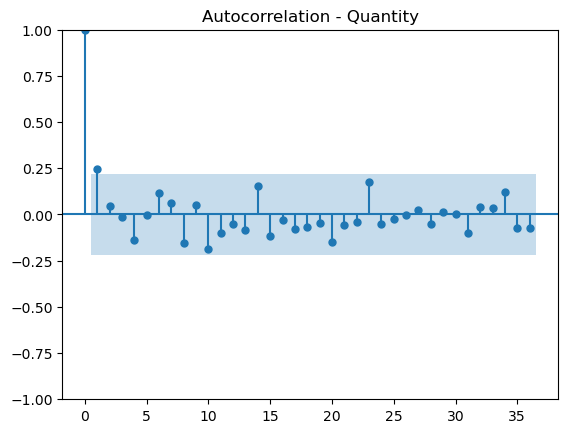

In [55]:
plt.figure(figsize=(8, 4))
plot_pacf(df_monthly, lags=36)
plt.title("Autocorrelation - Quantity")
plt.show()

### Prophet model
Prophet model is designed as a univariate time series forecasting. We have one datetime column and one target column.

### Feauture selection for Prophet model

In [116]:
df_for_prophet = df.drop(columns=['year', 'month', 'dim_product_sk', 'amount'], axis=1)

In [117]:
df_for_prophet.head()

,index,year_month,quantity
0,0,2019-01-01,95.0
1,1,2019-02-01,197.0
2,2,2019-03-01,123.0
3,3,2019-04-01,87.0
4,4,2019-05-01,158.0


### Grouping
Grouping quantites of all products by months.

In [61]:
df_final = (
    df_for_prophet.groupby('year_month', as_index=False).agg({'quantity': 'sum'})
)

In [65]:
df_for_prophet = df_final.copy()

In [66]:
df_for_prophet.head(5)

,year_month,quantity
0,2019-01-01,165313.0
1,2019-02-01,140022.0
2,2019-03-01,126374.0
3,2019-04-01,172013.0
4,2019-05-01,312183.0


In [67]:
df_for_prophet['year_month'] = pd.to_datetime(df_for_prophet['year_month'])

### Changing column names

In [69]:
df_for_prophet = df_for_prophet[['year_month', 'quantity']].rename(columns={'year_month':'ds', 'quantity' : 'y'})

In [70]:
df_for_prophet.head(2)

,ds,y
0,2019-01-01,165313.0
1,2019-02-01,140022.0


### Train test split

In [83]:
H = 12 # 12 months 

In [84]:
train = df_for_prophet.iloc[:-H].copy()
test = df_for_prophet.iloc[-H:].copy()

### Defining model

In [85]:
prophet_model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    interval_width=0.80    
)

### Fitting model

In [86]:
prophet_model.fit(train)

21:46:04 - cmdstanpy - INFO - Chain [1] start processing
21:46:05 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

In [88]:
future = prophet_model.make_future_dataframe(periods=H, freq='MS')

In [89]:
forecast = prophet_model.predict(future)

### Model Evaluation

In [90]:
pred_vs_actual = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_for_prophet.set_index('ds')['y'])

In [92]:
pred_test = pred_vs_actual.loc[test['ds']]

In [93]:
y_true = pred_test['y'].values

In [94]:
y_pred  = pred_test['yhat'].values

In [99]:
mae  = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
mape = (np.abs((y_true - y_pred) / y_true).mean() * 100)

In [101]:

print(f"MAE:  {mae:,.2f}")
print(f"MSE:  {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")


MAE:  31,128.04
MSE:  1,720,680,607.96
RMSE: 41,481.09
MAPE: 24.29%


### Final Forecasting

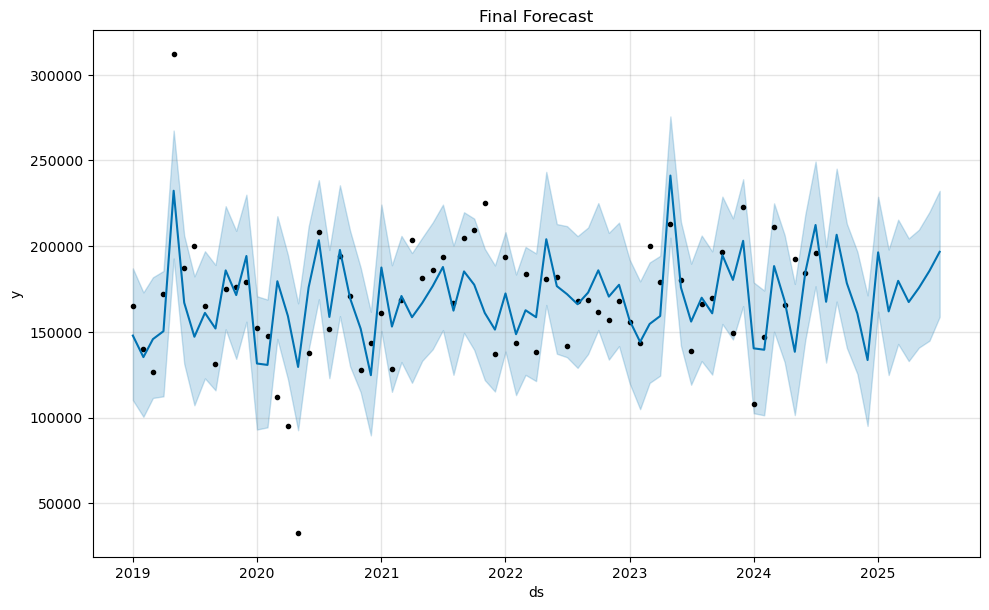

In [102]:
fig1 = prophet_model.plot(forecast)
plt.title('Final Forecast')
plt.show()

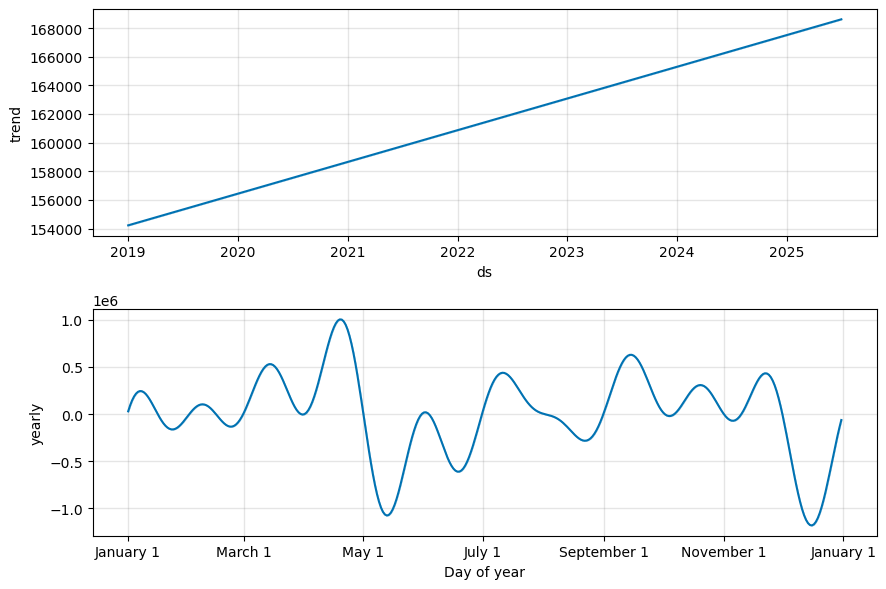

In [103]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

### Forecasting 2026

In [108]:
future = prophet_model.make_future_dataframe(periods=24, freq='MS')

In [109]:
forecast = prophet_model.predict(future)

In [110]:
forecast_2026 = forecast[forecast['ds'].dt.year == 2026]
print(forecast_2026[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

           ds           yhat     yhat_lower     yhat_upper
84 2026-01-01  181254.911743  144951.627950  218461.106726
85 2026-02-01  157476.423243  118480.836407  196719.087492
86 2026-03-01  171449.858184  135837.617308  208722.634879
87 2026-04-01  167382.470473  133071.497952  203644.900903
88 2026-05-01  212909.217983  178202.383026  248590.652811
89 2026-06-01  185536.430151  149995.047378  222121.354620
90 2026-07-01  180846.744055  143265.625454  217695.428644


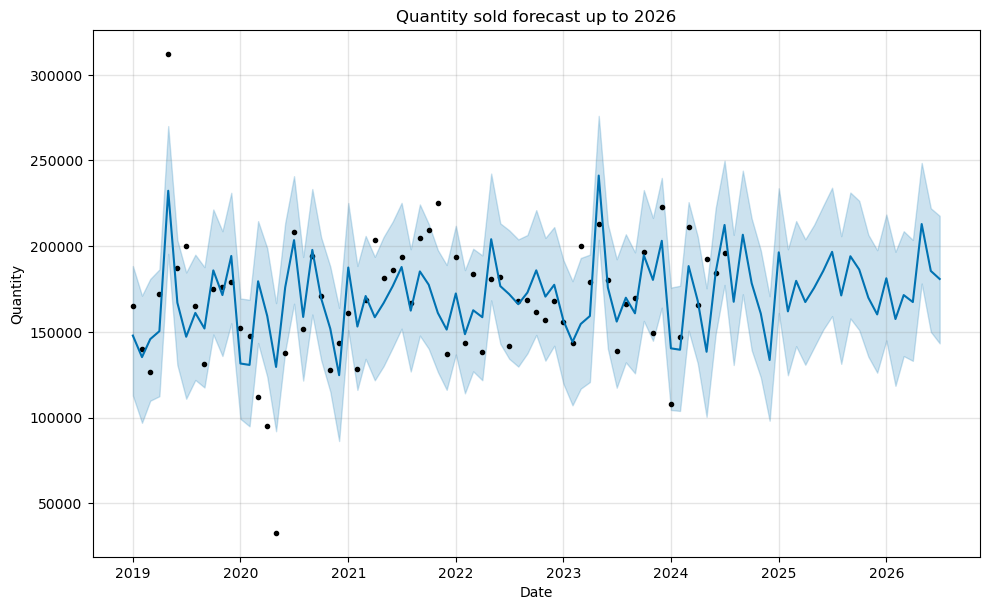

In [114]:
fig = prophet_model.plot(forecast)
plt.title("Quantity sold forecast up to 2026")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()